In [1]:
from glob import glob
import earthpy as et 
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import gdal
import ogr

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union, unary_union

import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
# ------
import os

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from rasterio.crs import CRS
import rioxarray as rxr
import earthpy as et

%matplotlib inline

# Read Data
Let's read the 3 bands of our dataset

In [2]:
raster_path = 'original/T36UXV_20200406T083559_TCI_10m.jp2'
with rio.open(raster_path, 'r', driver='JP2OpenJPEG') as src:
    print (src.crs)
    raster_img = src.read()
    raster_meta = src.meta

EPSG:32636


In [3]:
raster_img.shape

(3, 10980, 10980)

In [4]:
raster_img.shape

(3, 10980, 10980)

In [5]:
raster_img[2].shape

(10980, 10980)

# Visualize Bands
How much intesity have each bands, and how it looks like?

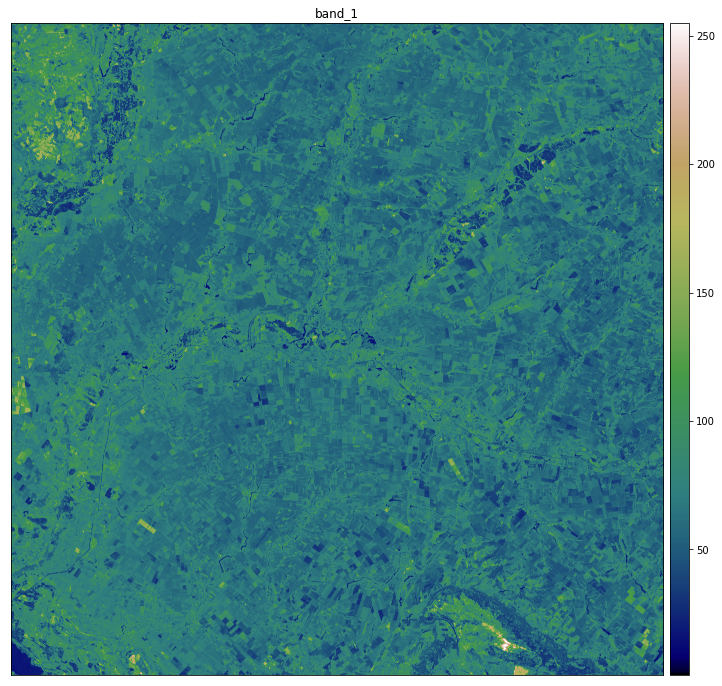

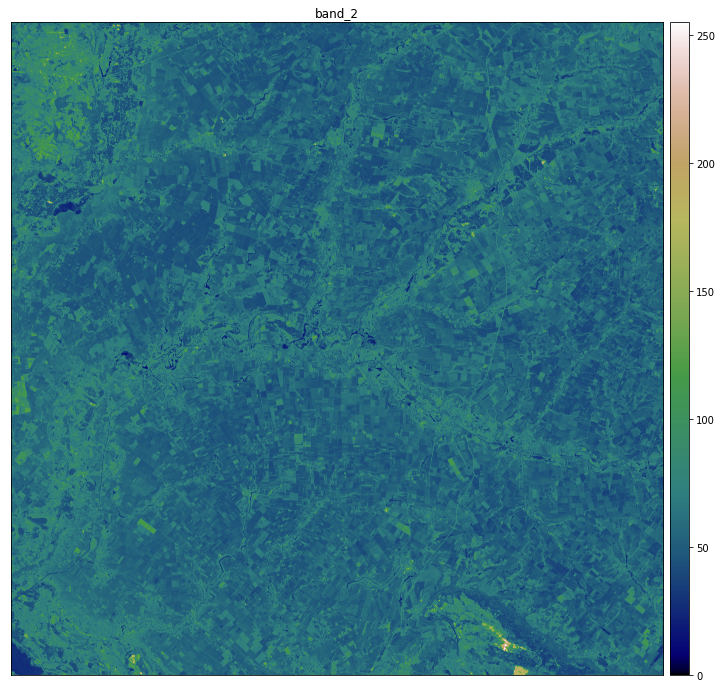

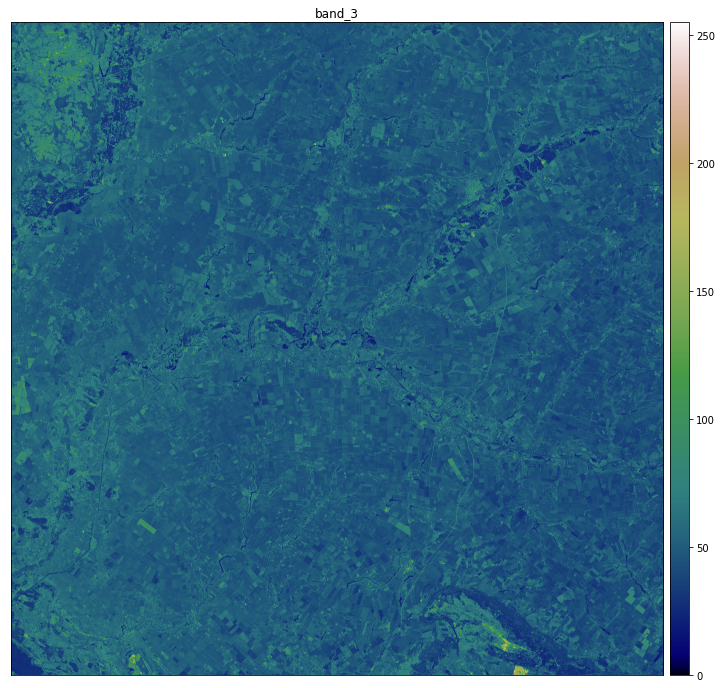

In [6]:
title = 'band_'
for i in range(raster_img.shape[0]):
    ep.plot_bands(raster_img[i],
             cmap='gist_earth',
             figsize=(20, 12),
             cols=6,
             title=title + str(i + 1))
plt.show()

# Histograms

Visualizing the bands of the hyperspectral image dataset helps us to understand the distribution of pixels/values of the bands. 

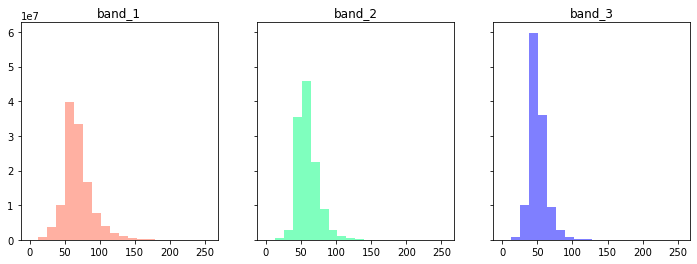

In [7]:
colors = ['tomato', 'springgreen', 'blue']

ep.hist(raster_img,
       colors=colors,
       title = ['band_1', 'band_2', 'band_3'],
       cols=3,
       alpha=0.5,
       figsize=(12, 4));

https://gis.stackexchange.com/questions/197945/geopandas-polygon-to-matplotlib-patches-polygon-conversion

# Reading raster files

In [8]:
raster_path = 'original/T36UXV_20200406T083559_TCI_10m.jp2'

In [9]:
with rio.open(raster_path, 'r', driver='JP2OpenJPEG') as src:
    print (src.crs)
    raster_img = src.read()
    raster_meta = src.meta

EPSG:32636


In [10]:
print(raster_img.shape)

(3, 10980, 10980)


In [11]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

# Reshaping rasters

In [12]:
raster_img = reshape_as_image(raster_img)

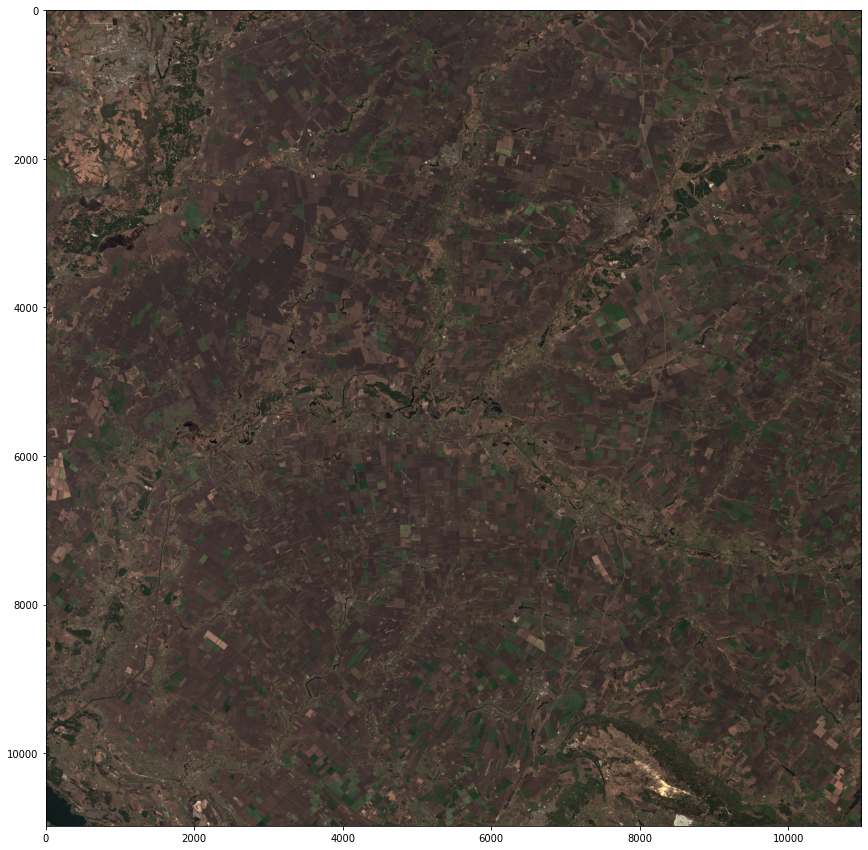

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(raster_img)

# Opening the labels

In [14]:
train_df = gpd.read_file('masks/Masks_T36UXV_20190427.shp')
print(len(train_df))
train_df.head(5)

936


id  Data  Code       Descriptio Comments                   Image  \
0  None  None   2.0   branch of tree     None  T36UXV_20190427T083601   
1  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   
2  None  None   2.0   brahch of tree     None  T36UXV_20190427T083601   
3  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   
4  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   

                                            geometry  
0  POLYGON ((35.62916 49.60293, 35.63015 49.60163...  
1  POLYGON ((35.65070 49.60254, 35.65248 49.60301...  
2  POLYGON ((35.63023 49.60826, 35.62960 49.60920...  
3  POLYGON ((35.62033 49.60905, 35.62064 49.60968...  
4  POLYGON ((35.60455 49.61078, 35.60597 49.61228...

In [15]:
train_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
src = rio.open(raster_path, 'r', driver="JP2OpenJPEG")
src.crs

CRS.from_epsg(32636)

In [17]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

http://projfinder.com/

They are all have same values as for EPSG:32636. I choose EPSG:4326 Name:WGS 84, because the same was in [Quantum Article](https://medium.datadriveninvestor.com/preparing-aerial-imagery-for-crop-classification-ce05d3601c68)(`WGS 84`)

0.	EPSG:4055 Name:Popular Visualisation CRS	Distance:0.210205
1.	EPSG:4324 Name:WGS 72BE	Distance:0.387179
2.	EPSG:4322 Name:WGS 72	Distance:0.387183
3.	EPSG:4740 Name:PZ-90	Distance:0.387236
4.	EPSG:4760 Name:WGS 66	Distance:0.387250
5.	EPSG:4326 Name:WGS 84	Distance:0.387250
6.	EPSG:4258 Name:ETRS89	Distance:0.387250
7.	EPSG:4276 Name:NSWC 9Z-2	Distance:0.387250
8.	EPSG:4200 Name:Pulkovo 1995	Distance:0.387747
9.	EPSG:4284 Name:Pulkovo 1942	Distance:0.387766

# Data masking using Rasterio

In [18]:
src = rio.open(raster_path, 'r', driver='JP2OpenJPEG')
src.xy(0, 0)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print('Rasterio failed to mask {} files'.format(len(failed)))

Rasterio failed to mask 936 files


In [19]:
train_df = gpd.read_file('masks/Masks_T36UXV_20190427.shp')
train_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
train_df.head()

id  Data  Code       Descriptio Comments                   Image  \
0  None  None   2.0   branch of tree     None  T36UXV_20190427T083601   
1  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   
2  None  None   2.0   brahch of tree     None  T36UXV_20190427T083601   
3  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   
4  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   

                                            geometry  
0  POLYGON ((35.62916 49.60293, 35.63015 49.60163...  
1  POLYGON ((35.65070 49.60254, 35.65248 49.60301...  
2  POLYGON ((35.63023 49.60826, 35.62960 49.60920...  
3  POLYGON ((35.62033 49.60905, 35.62064 49.60968...  
4  POLYGON ((35.60455 49.61078, 35.60597 49.61228...

In [21]:
# Let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]
print(train_df.crs)
# Assigning crs
train_df.to_crs({'init': 'epsg:4326'})

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

epsg:4326


/home/diakap/miniconda3/envs/py38/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/diakap/miniconda3/envs/py38/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [22]:
train_df.crs

<Derived Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Turkey. Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
train_df.head()

id  Data  Code       Descriptio Comments                   Image  \
0  None  None   2.0   branch of tree     None  T36UXV_20190427T083601   
1  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   
2  None  None   2.0   brahch of tree     None  T36UXV_20190427T083601   
3  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   
4  None  None   1.0  color+ feathers     None  T36UXV_20190427T083601   

                                            geometry  
0  POLYGON ((689961.152 5497804.667, 690037.456 5...  
1  POLYGON ((691518.623 5497815.456, 691645.003 5...  
2  POLYGON ((690017.383 5498399.293, 689968.112 5...  
3  POLYGON ((689299.133 5498462.011, 689319.252 5...  
4  POLYGON ((688152.716 5498615.331, 688249.512 5...

In [24]:
src = rio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "article" # folder where we have saved maske_image
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(num) + '_img' + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))
print('*****')

Rasterio failed to mask 435 files
*****


# Data Preparation
If you want to make semantic segmentation not to just classify the fields, but also to find their boundaries, you can do a field/not field binary segmentation or a more complex multiclass segmentation for each class binary mask. Let’s prepare data for semantic segmentation! One solution for this is to convert vector polygons to raster and then cut it into tiles. We will use the function rasterio.rasterize.

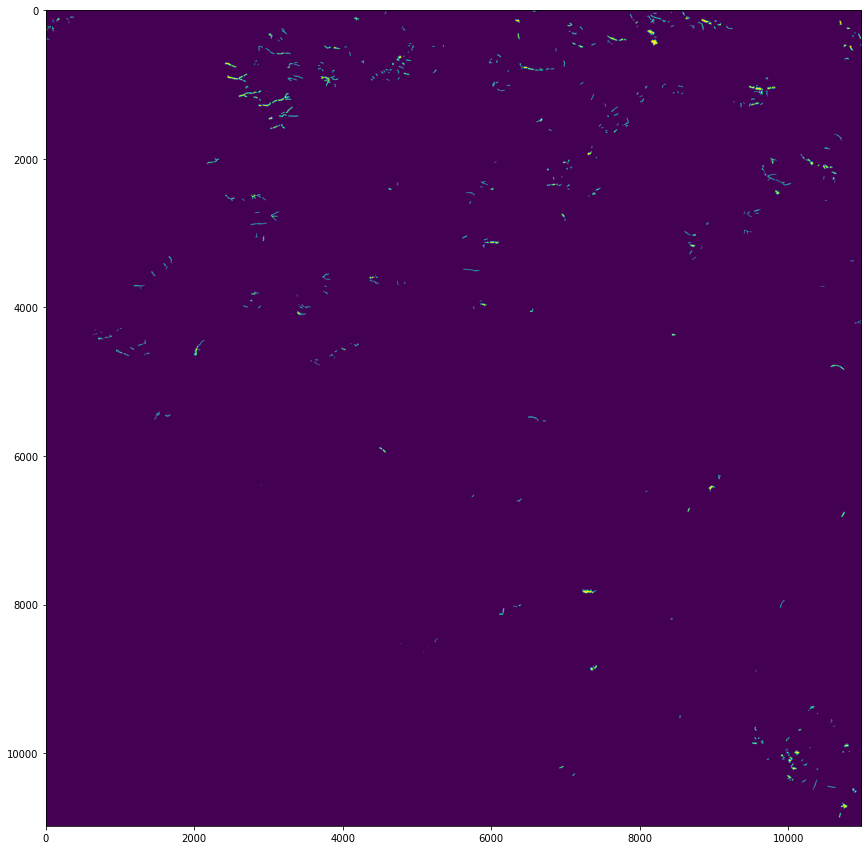

In [25]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts=[]
    
    # make a polygon from multipolygon
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transform polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_field segmentation

poly_shp = []
img_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            
mask = rasterize(shapes=poly_shp,
                out_shape=img_size)

# plotting the mask
plt.figure(figsize=(15, 15))
plt.imshow(mask);

In [26]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rio.open('original/label.jp2', 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)